In [1]:
# Install necessary libraries
!pip install -q pytorch-lightning

In [2]:
# Import libraries
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import TensorBoardLogger

# Set random seed for reproducibility
torch.manual_seed(66)

In [3]:
image_dir_name = './satelight_data'

In [4]:
SIZE_X, SIZE_Y = 5000, 8000 #SIZE of picture
nx, ny = 12, 20 # number of crops by axis

size_x, size_y = SIZE_X//nx, SIZE_Y//ny
print(size_x, size_y)

416 400


## Read images and organize data in pair winter-summer

In [5]:
cities = set([x.split('_')[0] for x in os.listdir(image_dir_name)])

# axis 0 : number of element in dataset
# axis 1 : 0 - summer image, 1 - winter image
# axis 2 : x size
# axis 3 : y size
images = [] # image list

# just to simplify the model
resize = transforms.Resize((112, 112))

for city in cities:
    summer_image = torchvision.io.read_image(os.path.join(image_dir_name, f'{city}_summer.jpg')).float() / 256
    winter_image = torchvision.io.read_image(os.path.join(image_dir_name, f'{city}_winter.jpg')).float() / 256
    
    for i in range(nx):
        for j in range(ny):
            summer_crop = summer_image[:, (i*size_x):((i+1)*size_x), (j*size_y):((j+1)*size_y)]
            winter_crop = winter_image[:, (i*size_x):((i+1)*size_x), (j*size_y):((j+1)*size_y)]
            images.append(torch.stack((resize(summer_crop), resize(winter_crop)), axis=0))

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Plot sample images from dataset

[ 976 1486  665   34]


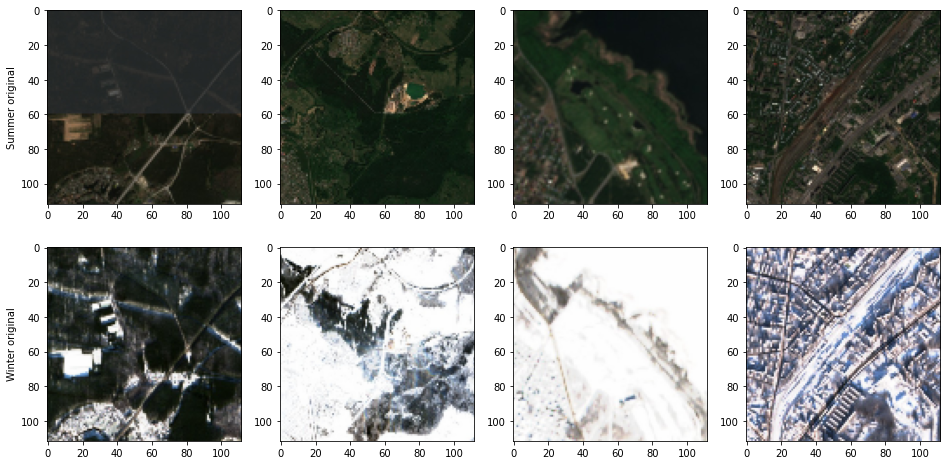

In [68]:
import numpy as np

indexes = np.random.choice(np.arange(len(images)), size=4, replace=False)
print(indexes)

fig, ax = plt.subplots(2, 4, figsize=(16, 8))

ax[0, 0].set_ylabel('Summer original')
ax[1, 0].set_ylabel('Winter original')

for k, i in enumerate(indexes):
    ax[0, k].imshow(resize(images[i][0, :]).permute((1,2,0)))
    ax[1, k].imshow(resize(images[i][1, :]).permute((1,2,0)))

## Class for dataset

In [8]:
from copy import deepcopy

# Convert the Hugging Face dataset to PyTorch dataset
class SatelightDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=False):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        self.data[idx]

        if self.transform:
            tmp = self.data[idx]
            tmp[0, :] = (tmp[0, :]- mean_summer)/std_summer
            tmp[1, :] = (tmp[1, :] - mean_winter)/std_winter
            return tmp

        return self.data[idx]

train-test split

In [9]:
# Define the ratio for splitting the dataset
train_ratio = 0.8
val_ratio = 1 - train_ratio

# Calculate the sizes of training and validation datasets
train_size = int(train_ratio * len(images))
val_size = len(images) - train_size

# Split the dataset into training and validation datasets
train_dataset, val_dataset = random_split(images, [train_size, val_size])
train_dataset, val_dataset = SatelightDataset(train_dataset), SatelightDataset(train_dataset)

Create dataloader

In [10]:
batch_size=12
train_dataloader, val_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8), DataLoader(val_dataset, batch_size=batch_size, num_workers=8)

## Model architecture
written provided guideline at https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/gan/cycle_gan/__init__.py

In [11]:
class GeneratorResNet(nn.Module):
    """
    The generator is a residual network.
    """

    def __init__(self, input_channels: int, n_residual_blocks: int):
        super().__init__()
        out_features = 64
        layers = [
            nn.Conv2d(input_channels, out_features, kernel_size=7, padding=3, padding_mode='reflect'),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        for _ in range(2):
            out_features *= 2
            layers += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        for _ in range(n_residual_blocks):
            layers += [ResidualBlock(out_features)]

        for _ in range(2):
            out_features //= 2
            layers += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            
        layers += [nn.Conv2d(out_features, input_channels, 7, padding=3, padding_mode='reflect'), torch.nn.Tanh()]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return (self.layers(x)+1) * 0.5
    
class ResidualBlock(nn.Module):
    """
    This is the residual block, with two convolution layers.
    """

    def __init__(self, in_features: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor):
        return x + self.block(x)

In [12]:
from typing import Tuple

class Discriminator(nn.Module):

    def __init__(self, input_shape: Tuple[int, int, int]):
        super().__init__()
        channels, height, width = input_shape
        self.output_shape = (1, height // 2 ** 6, width // 2 ** 4)

        self.layers = nn.Sequential(
            DiscriminatorBlock(channels, 16, normalize=False),
            DiscriminatorBlock(16, 32),
            DiscriminatorBlock(32, 64),
            DiscriminatorBlock(64, 128),
            DiscriminatorBlock(128, 256),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(256, 64, kernel_size=4, padding=1),
            nn.Conv2d(64, 1, kernel_size=3, padding=0)
        )

    def forward(self, img):
        return self.layers(img).flatten()


class DiscriminatorBlock(nn.Module):

    def __init__(self, in_filters: int, out_filters: int, normalize: bool = True):
        super().__init__()
        layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_filters))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [16]:
# Define the CycliGAN Lightning Module
class CyclicGAN(pl.LightningModule):
    def __init__(self, n_generator_blocks=7):
        super().__init__()
        
        # generator summer -> winter
        self.gen_X = GeneratorResNet(input_channels=3, n_residual_blocks=n_generator_blocks)
        # generator winter <- summer
        self.gen_Y = GeneratorResNet(input_channels=3, n_residual_blocks=n_generator_blocks)
        
        # discriminator for summer
        self.dis_X = Discriminator((3, 310, 330))
        self.dis_Y = Discriminator((3, 310, 330))

        self.lr = 0.0002
        self.automatic_optimization = False
        
        self.gan_loss = torch.nn.BCEWithLogitsLoss()#torch.nn.MSELoss()
        self.cycle_loss = torch.nn.L1Loss()
        self.identity_loss = torch.nn.L1Loss()
        
    def set_valdataloader(self, validate_dataloader):
        self.val_dataloader = validate_dataloader


    def forward(self, X, direct_way=True):
        return (self.gen_X(X) if direct_way else self.gen_Y(X))

    def adversarial_loss(self, y_pred, y_true):
        return nn.BCELoss()(y_pred, y_true)
    
    def configure_optimizers(self):
        self.opt_gx = torch.optim.Adam(self.gen_X.parameters(), lr=self.lr)
        self.opt_gy = torch.optim.Adam(self.gen_Y.parameters(), lr=self.lr)
        self.opt_dx = torch.optim.Adam(self.dis_X.parameters(), lr=self.lr)
        self.opt_dy = torch.optim.Adam(self.dis_Y.parameters(), lr=self.lr)
        return self.opt_gx, self.opt_gy, self.opt_dx, self.opt_dy
    def optimizers(self):
        return self.opt_gx, self.opt_gy, self.opt_dx, self.opt_dy

    def training_step(self, batch):
        imgs_x, imgs_y = batch[:, 0, :].float(), batch[:, 1, :].float()

        opt_gx, opt_gy, opt_dx, opt_dy = self.optimizers()
        
        gen_y = self.forward(imgs_x)
        gen_x = self.forward(imgs_y, direct_way=False)
        
        device = self.device
        
        for i in range(3):
            # Step 1 : optimize generator
            
            loss_gan = self.gan_loss(self.dis_Y(gen_y),
                                     torch.ones(gen_y.size(0)).to(device)) \
                       + self.gan_loss(self.dis_X(gen_x),
                                     torch.ones(gen_x.size(0)).to(device))
            
            #loss_gan = - torch.mean(self.dis_Y(gen_y)) - torch.mean(self.dis_X(gen_x))
            loss_cycle = (self.cycle_loss(self.forward(gen_y, direct_way=False), imgs_x.to(device)) \
                          + self.cycle_loss(self.forward(gen_x, direct_way=True), imgs_y.to(device)))
            loss_identity = (self.identity_loss(self.forward(gen_y, direct_way=False), imgs_x.to(device)) \
                          + self.identity_loss(self.forward(gen_x, direct_way=True), imgs_y.to(device)))
            loss = loss_gan + loss_cycle + loss_identity
            opt_gx.zero_grad()
            opt_gy.zero_grad()
            self.manual_backward(loss)
            opt_gx.step()
            opt_gy.step()
            self.untoggle_optimizer(opt_gx)
            self.untoggle_optimizer(opt_gy)

            del gen_y, gen_x
            gen_y = self.forward(imgs_x)
            gen_x = self.forward(imgs_y, direct_way=False)
            
        loss = loss.detach()
        
        # step 2 : optimize discriminator
        
        loss_discriminator = self.gan_loss(self.dis_X(imgs_x), torch.ones(imgs_x.size(0)).to(device)) \
                              + self.gan_loss(self.dis_X(gen_x), torch.zeros(gen_x.size(0)).to(device)) \
                              + self.gan_loss(self.dis_Y(imgs_y), torch.ones(imgs_y.size(0)).to(device)) \
                              + self.gan_loss(self.dis_Y(gen_y), torch.zeros(gen_y.size(0)).to(device))
        '''
        loss_discriminator = - torch.mean(self.dis_X(imgs_x)) - torch.mean(self.dis_Y(imgs_y)) \
                             + torch.mean(self.dis_X(gen_x)) + torch.mean(self.dis_Y(gen_y))
        '''
        opt_dx.zero_grad()
        opt_dy.zero_grad()
        self.manual_backward(loss_discriminator)
        opt_dx.step()
        opt_dy.step()
        self.untoggle_optimizer(opt_dx)
        self.untoggle_optimizer(opt_dy)

        self.log_dict({"d_loss": loss_discriminator, "g_loss": loss})
        
        del imgs_x, imgs_y, gen_y, gen_x

    def on_train_epoch_end(self):
        # TBU
        sample_imgs = next(iter(self.val_dataloader))[:16, :].float()
        summer_imgs, winter_imgs = sample_imgs[:, 0, :], sample_imgs[:, 1, :]
        summer_gen, winter_gen = self.forward(winter_imgs.to(self.device), direct_way=False), self.forward(summer_imgs.to(self.device))     
        
        summer_gem, winter_gen = summer_gen.to('cpu'), winter_gen.to('cpu')
        
        grid_original = torchvision.utils.make_grid(summer_imgs, nrow=4, normalize=True)
        grid_gen = torchvision.utils.make_grid(summer_gen, nrow=4, normalize=True)
                              
        self.logger.experiment.add_image('Original Summer Images', grid_original, self.current_epoch)
        self.logger.experiment.add_image('Generated Summer Images', grid_gen, self.current_epoch)
        
        grid_original = torchvision.utils.make_grid(winter_imgs, nrow=4, normalize=True)
        grid_gen = torchvision.utils.make_grid(winter_gen, nrow=4, normalize=True)
                              
        self.logger.experiment.add_image('Original Winter Images', grid_original, self.current_epoch)
        self.logger.experiment.add_image('Generated Winter Images', grid_gen, self.current_epoch)

## Train model

In [17]:
trainer = pl.Trainer(max_epochs=70, 
                     devices=[1],
                     logger=pl.loggers.TensorBoardLogger("logs/", name="cycle-GAN"))

model = CyclicGAN()
model.set_valdataloader(val_dataloader)

trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type              | Params
----------------------------------------------------
0 | gen_X         | GeneratorResNet   | 9.0 M 
1 | gen_Y         | GeneratorResNet   | 9.0 M 
2 | dis_X         | Discriminator     | 960 K 
3 | dis_Y         | Discriminator     | 960 K 
4 | gan_loss      | BCEWithLogitsLoss | 0     
5 | cycle_loss    | L1Loss            | 0     
6 | identity_loss | L1Loss            | 0     
----------------------------------------------------
20.0 M    Trainable params
0         Non-trainable params
20.0 M    Total params
79.826    Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=70` reached.


In [1]:
%load_ext tensorboard
%tensorboard --logdir ./logs/ --bind_all

Reusing TensorBoard on port 6008 (pid 63934), started 2 days, 7:09:24 ago. (Use '!kill 63934' to kill it.)

## Sample generations

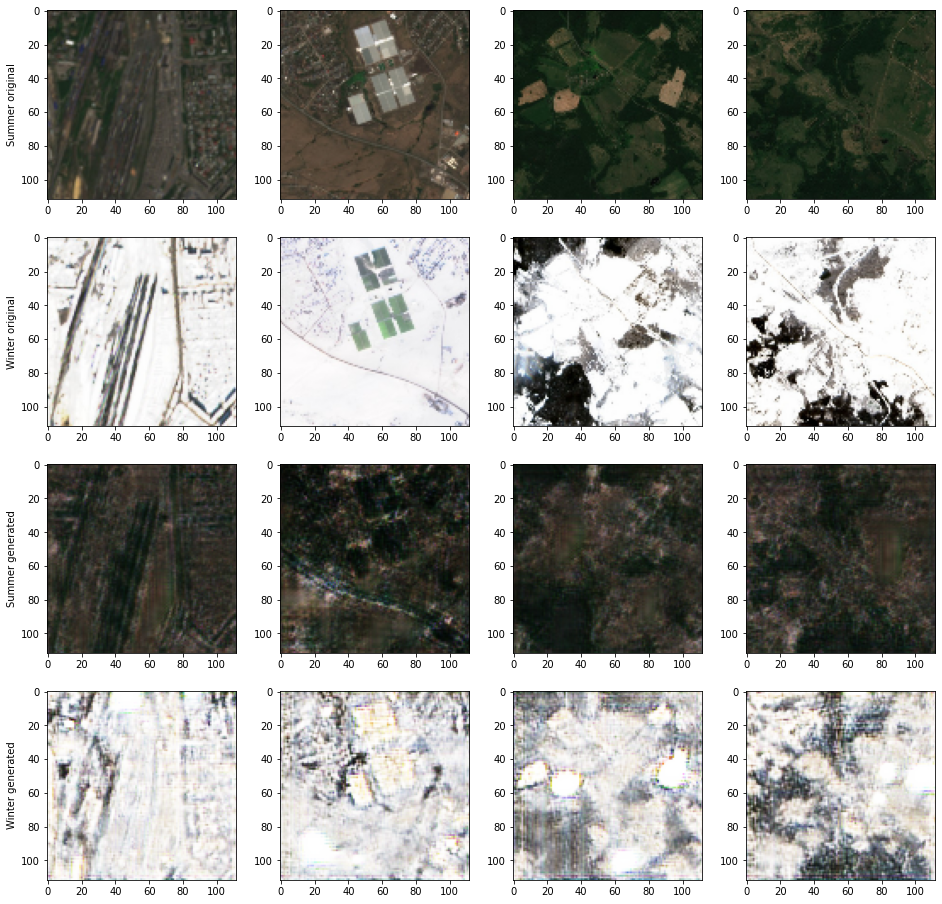

In [19]:
import numpy as np

indexes = np.random.choice(np.arange(len(images)), size=4, replace=False)
model.eval()
model.to('cpu')
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

ax[0, 0].set_ylabel('Summer original')
ax[1, 0].set_ylabel('Winter original')
ax[2, 0].set_ylabel('Summer generated')
ax[3, 0].set_ylabel('Winter generated')

for k, i in enumerate(indexes):
    
    image_x = images[i][0, :] #* std_summer + mean_summer
    image_y = images[i][1, :] #* std_winter + mean_winter
    
    ax[0, k].imshow(resize(image_x).permute((1,2,0)))
    ax[1, k].imshow(resize(image_y).permute((1,2,0)))
    
    y = resize(images[i][1, :]).unsqueeze(0).float()
    x = resize(images[i][0, :]).unsqueeze(0).float()
    
    gen_x = model(y, False).detach().to('cpu').squeeze() #* std_summer + mean_summer
    gen_y = model(x, True).detach().to('cpu').squeeze() #* std_winter + mean_winter
    
    
    ax[2, k].imshow(gen_x.permute((1,2,0)))
    ax[3, k].imshow(gen_y.permute((1,2,0)))

In [20]:
torch.save(model.state_dict(), './cycleGAN.pt')

## Test model

In [48]:
city = 'perm'

image_s = torchvision.io.read_image(os.path.join(image_dir_name, f'{city}_summer.jpg')).float() / 256
image_w = torchvision.io.read_image(os.path.join(image_dir_name, f'{city}_winter.jpg')).float() / 256

In [45]:
div = 1

image_s_generated = torch.zeros([3, nx*112//div, ny*112//div])
image_w_generated = torch.zeros([3, nx*112//div, ny*112//div])

size_x, size_y = 416 * div, 400 * div

for i in range(nx//div):
    for j in range(ny//div):
        x = resize(image_s[:, (i*size_x):((i+1)*size_x), (j*size_y):((j+1)*size_y)]).unsqueeze(0).float()
        y = resize(image_w[:, (i*size_x):((i+1)*size_x), (j*size_y):((j+1)*size_y)]).unsqueeze(0).float()
        
        gen_x = model(y, False).detach().to('cpu').squeeze() #* std_summer + mean_summer
        gen_y = model(x, True).detach().to('cpu').squeeze()
        
        image_s_generated[:, (i*112):((i+1)*112), (j*112):((j+1)*112)] = gen_x
        image_w_generated[:, (i*112):((i+1)*112), (j*112):((j+1)*112)] = gen_y

In [62]:
image_s_generated = torch.zeros([3, 2 * 112, 3 * 112])
image_w_generated = torch.zeros([3, 2 * 112, 3 * 112])

image_s_real = torch.zeros([3, 2 * 112, 3 * 112])
image_w_real = torch.zeros([3, 2 * 112, 3 * 112])

size_x, size_y = 128 * 2, 128 * 2

for i in range(2):
    for j in range(3):
        x = resize(image_s[:, (i*size_x):((i+1)*size_x), (j*size_y):((j+1)*size_y)]).unsqueeze(0).float()
        y = resize(image_w[:, (i*size_x):((i+1)*size_x), (j*size_y):((j+1)*size_y)]).unsqueeze(0).float()
        
        gen_x = model(y, False).detach().to('cpu').squeeze() #* std_summer + mean_summer
        gen_y = model(x, True).detach().to('cpu').squeeze()
        
        image_s_generated[:, (i*112):((i+1)*112), (j*112):((j+1)*112)] = gen_x
        image_w_generated[:, (i*112):((i+1)*112), (j*112):((j+1)*112)] = gen_y
        
        image_s_real[:, (i*112):((i+1)*112), (j*112):((j+1)*112)] = x.squeeze()
        image_w_real[:, (i*112):((i+1)*112), (j*112):((j+1)*112)] = y.squeeze()

In [65]:
metr = torch.nn.MSELoss()

metr(image_s_generated, image_s_real), metr(image_w_generated, image_w_real)

(tensor(0.0071), tensor(0.0805))

## Plot generated maps

Text(0.5, 1.0, 'Perm winter, generated')

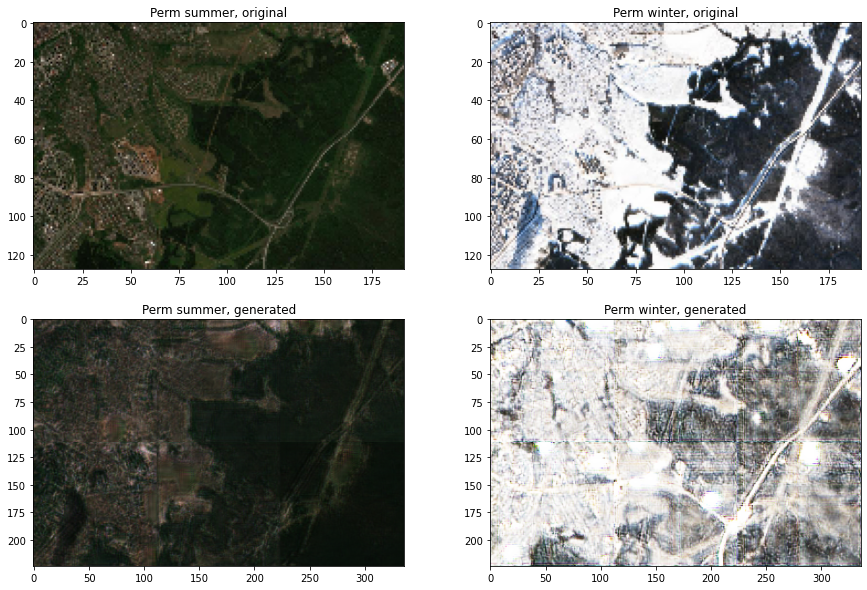

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].imshow(image_s[:, ::4, ::4].permute((1,2,0)))
ax[0, 0].set_title('Perm summer, original')
ax[0, 1].imshow(image_w[:, ::4, ::4].permute((1,2,0)))
ax[0, 1].set_title('Perm winter, original')
                
ax[1, 0].imshow(image_s_generated.permute((1,2,0)))
ax[1, 0].set_title('Perm summer, generated')
ax[1, 1].imshow(image_w_generated.permute((1,2,0)))
ax[1, 1].set_title('Perm winter, generated')